# Introduction to Spark ML: An application to Sentiment Analysis

In [1]:
%%bash 
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating requirement already satisfied
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=759f1480e0f981e7b041738f3c20d9f452be03eeb24b49195cd372c04d906af9
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
%%bash

# Download the data files from github

data_file_1=imdb_reviews_preprocessed.parquet
data_file_2=sentiments.parquet
data_file_3=tweets.parquet

# If data_file_1 file does not exist in the colab environment
if [[ ! -f ${data_file_1} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/wewilli1/ist718_data/master/${data_file_1} 
fi

# If data_file_1 file does not exist in the colab environment
if [[ ! -f ${data_file_2} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/wewilli1/ist718_data/master/${data_file_2} 
fi

# If data_file_1 file does not exist in the colab environment
if [[ ! -f ${data_file_3} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/wewilli1/ist718_data/master/${data_file_3} 
fi

--2022-10-09 12:52:18--  https://raw.githubusercontent.com/wewilli1/ist718_data/master/imdb_reviews_preprocessed.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21597134 (21M) [application/octet-stream]
Saving to: ‘imdb_reviews_preprocessed.parquet’

     0K .......... .......... .......... .......... ..........  0% 4.09M 5s
    50K .......... .......... .......... .......... ..........  0% 5.85M 4s
   100K .......... .......... .......... .......... ..........  0% 22.8M 3s
   150K .......... .......... .......... .......... ..........  0% 18.4M 3s
   200K .......... .......... .......... .......... ..........  1% 7.08M 3s
   250K .......... .......... .......... .......... ..........  1%  132M 2s
   300K .......... .......... .......... .......... .

# Spark ML

In previous versions of Spark, most Machine Learning funcionality was provided through RDD (Resilient Distributed Datasets). However, to improve performance and communicability of results, Spark developers ported the ML functionality to work almost exclusively with DataFrames. Future releases of Spark will not update the support of ML with RDDs.

In this modern Spark ML approach, there are _Estimators_ and _Transformers_. Estimators have some parameters that need to be fit into the data. After fitting, Estimators return Transformers. Tranformers can be applied to dataframes, taking one (or several) columns as input and creating none (or several) columns as output.

A _Pipeline_ combines several _Tranformers_ with a final _Estimator_. The _Pipeline_, therefore, can be fit to the data because the final step of the process (the _Estimator_) is fit to the data. The result of the fitting is a pipelined _Transformer_ that takes an input dataframe through all the stages of the Pipeline.

There is a third type of functionality that allows to select features.

For example, for analyzing text, a typical pipelined estimator is as follows:

<img src="http://spark.apache.org/docs/latest/img/ml-Pipeline.png" alt="ML Pipeline" style="width: 100%;"/>

After fitting, the Pipeline becomes a transformer:

<img src="http://spark.apache.org/docs/latest/img/ml-PipelineModel.png" alt="ML Model" style="width: 100%;"/>
(Images from http://spark.apache.org/docs/latest/ml-pipeline.html)

Importantly, transformers can be saved and exchanged with other data scientists, improving reproducibility.

## Loading packages and connecting to Spark cluster

In [3]:
from __future__ import division
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
import glob
import subprocess
import numpy as np
import pandas as pd
import os
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

### Transformers and Estimators

Let's define an example dataframe with documents

In [4]:
documents_df = spark.sparkContext.parallelize([
        [1, 'cats cats are cute', 0],
        [2, 'dogs are playfull', 0],
        [3, 'lions are big', 1],
        [4, 'cars are fast', 1]]).toDF(['doc_id', 'text', 'user_id'])
documents_df.toPandas()

,doc_id,text,user_id
0,1,cats cats are cute,0
1,2,dogs are playfull,0
2,3,lions are big,1
3,4,cars are fast,1


There are several ways of transforming the data from raw input to something that can be analyzed with a statistical model.

Some examples of such transformers are displayed below:

#### Tokenizer

Suppose that we want to split the document into separate words where each word is a _token_. This is what `Tokenizer` does.

In [5]:
from pyspark.ml.feature import Tokenizer

Almost all transfomers and estimators require you to specificy the input column of the dataframe and the output column that will be added to the dataframe.

In [6]:
# the tokenizer object
tokenizer = Tokenizer().setInputCol('text').setOutputCol('words')

We can now transform the dataframe

In [7]:
tokenizer.transform(documents_df).show()

+------+------------------+-------+--------------------+
|doc_id|              text|user_id|               words|
+------+------------------+-------+--------------------+
|     1|cats cats are cute|      0|[cats, cats, are,...|
|     2| dogs are playfull|      0|[dogs, are, playf...|
|     3|     lions are big|      1|   [lions, are, big]|
|     4|     cars are fast|      1|   [cars, are, fast]|
+------+------------------+-------+--------------------+



#### CountVectorizer

This transformer counts how many times a word appears in a list and produces a vector with such counts. This is very useful for text analysis.

In [8]:
from pyspark.ml.feature import CountVectorizer

A `CountVectorizer` is different from a `Tokenizer` because it needs to learn how many different tokens there are in the input column. With that number, it will output vectors with consistent dimensions. Therefore, `CountVectorizer` is an `Estimator` that, when fitted, returns a `Transformer`.

In [9]:
count_vectorizer_estimator = CountVectorizer().setInputCol('words').setOutputCol('features')

Now we need to use the words column that was generated by the `tokenizer` transformer

In [10]:
count_vectorizer_transformer = count_vectorizer_estimator.fit(tokenizer.transform(documents_df))
count_vectorizer_transformer.vocabulary

['are', 'cats', 'fast', 'playfull', 'big', 'dogs', 'lions', 'cute', 'cars']

which results in:

In [11]:
count_vectorizer_transformer.transform(tokenizer.transform(documents_df)).show(truncate=False)

+------+------------------+-------+-----------------------+-------------------------+
|doc_id|text              |user_id|words                  |features                 |
+------+------------------+-------+-----------------------+-------------------------+
|1     |cats cats are cute|0      |[cats, cats, are, cute]|(9,[0,1,7],[1.0,2.0,1.0])|
|2     |dogs are playfull |0      |[dogs, are, playfull]  |(9,[0,3,5],[1.0,1.0,1.0])|
|3     |lions are big     |1      |[lions, are, big]      |(9,[0,4,6],[1.0,1.0,1.0])|
|4     |cars are fast     |1      |[cars, are, fast]      |(9,[0,2,8],[1.0,1.0,1.0])|
+------+------------------+-------+-----------------------+-------------------------+



In the cell below, we transform using a new dataframe which has an unseen word `lizard`.  Notice that lizard does not appear in the vocabulary that was present during the fit operation above.  Since lizard is not included in the vocabulary, the features column in row 1 does not include lizard in the features.  In fact, the features col of row 1 indicates that only 2 words are present when in fact there is 3 words present.  There are only 2 words present in the features column because the word `lizard` was not present during the fit operation.  This allows us to train a model and then make predictions on unseen data that might contain some words that were not present during the fit process.  In this notebook, we will train a model using IMDB movie data and then make predictions on tweets from the 2016 election using the same model trained on IMDB data.  

In [12]:
# create a new dataframe that contains an unseen word 'lizard'
documents_df1 = spark.sparkContext.parallelize([
        [1, 'lizards are cute', 0],
        [2, 'dogs are playfull', 0],
        [3, 'lions are big', 1],
        [4, 'cars are fast', 1]]).toDF(['doc_id', 'text', 'user_id'])

# transform the new dataframe and notice that lizard is not in the feature data
count_vectorizer_transformer.transform(tokenizer.transform(documents_df1)).show(truncate=False)

# print the vocabulary created during the fit process, notice that lizard is not present
print(count_vectorizer_transformer.vocabulary)

+------+-----------------+-------+---------------------+-------------------------+
|doc_id|text             |user_id|words                |features                 |
+------+-----------------+-------+---------------------+-------------------------+
|1     |lizards are cute |0      |[lizards, are, cute] |(9,[0,7],[1.0,1.0])      |
|2     |dogs are playfull|0      |[dogs, are, playfull]|(9,[0,3,5],[1.0,1.0,1.0])|
|3     |lions are big    |1      |[lions, are, big]    |(9,[0,4,6],[1.0,1.0,1.0])|
|4     |cars are fast    |1      |[cars, are, fast]    |(9,[0,2,8],[1.0,1.0,1.0])|
+------+-----------------+-------+---------------------+-------------------------+

['are', 'cats', 'fast', 'playfull', 'big', 'dogs', 'lions', 'cute', 'cars']


The column `features` is a sparse vector representation. For example, assume that the first document (document id 1) has the following features: 

(9,[0,1,6],[1.0,2.0,1.0]) 

The '9' indicates that there are a total of 9 features or words.

The \[0,1,6] indicates that the words in this document correspond to vocabulary indices (see vocabulary below) 0, 1, and 6.  Note that this mapping can change from run to run.  By looking at the vocabulary learned by `count_vectorizer_transformer`, we can look up which words those feature indices refer to.

The \[1.0,2.0,1.0] indicates the count of each word in the document.

## Pipelines

Sometimes, we have long preprocessing steps that take raw data and transform it through several stages. As explained before, these complex transformations can be captured by Pipelines.

Pipelines are always estimators, even when they contain several transformers. After a pipeline is `fit` to the data, the pipeline becomes a transformer.

We will now define a pipeline that takes the raw `text` column and produces the `features` column previously explained

In [13]:
from pyspark.ml import Pipeline

In [14]:
pipeline_cv_estimator = Pipeline(stages=[tokenizer, count_vectorizer_estimator])

In [15]:
pipeline_cv_transformer = pipeline_cv_estimator.fit(documents_df)

In [16]:
pipeline_cv_transformer.transform(documents_df).show()

+------+------------------+-------+--------------------+--------------------+
|doc_id|              text|user_id|               words|            features|
+------+------------------+-------+--------------------+--------------------+
|     1|cats cats are cute|      0|[cats, cats, are,...|(9,[0,1,4],[1.0,2...|
|     2| dogs are playfull|      0|[dogs, are, playf...|(9,[0,2,6],[1.0,1...|
|     3|     lions are big|      1|   [lions, are, big]|(9,[0,3,5],[1.0,1...|
|     4|     cars are fast|      1|   [cars, are, fast]|(9,[0,7,8],[1.0,1...|
+------+------------------+-------+--------------------+--------------------+



In more complex scenarios, you can even chain Pipeline transformers. We will see this case in the actual use case below.

For a more detail explanation of Pipelines, Estimators, and Transformers, [see here](http://spark.apache.org/docs/latest/ml-pipeline.html)

## Load sentiment data

In [17]:
sentiments_df =  spark.read.parquet('sentiments.parquet')

In [18]:
sentiments_df.printSchema()

root
 |-- word: string (nullable = true)
 |-- sentiment: long (nullable = true)



In [19]:
sentiments_df.show(5)

+-------------+---------+
|         word|sentiment|
+-------------+---------+
|   gratefully|        1|
|gratification|        1|
|    gratified|        1|
|    gratifies|        1|
|      gratify|        1|
+-------------+---------+
only showing top 5 rows



The schema is very simple: for each word, we have whether it is positive (+1) or negative (-1)

In [20]:
# a sample of positive words
sentiments_df.where(fn.col('sentiment') == 1).show(5)

+-------------+---------+
|         word|sentiment|
+-------------+---------+
|   gratefully|        1|
|gratification|        1|
|    gratified|        1|
|    gratifies|        1|
|      gratify|        1|
+-------------+---------+
only showing top 5 rows



In [21]:
# a sample of negative words
sentiments_df.where(fn.col('sentiment') == -1).show(5)

+----------+---------+
|      word|sentiment|
+----------+---------+
|   2-faced|       -1|
|   2-faces|       -1|
|  abnormal|       -1|
|   abolish|       -1|
|abominable|       -1|
+----------+---------+
only showing top 5 rows



Lets see how many of each category we have

In [22]:
sentiments_df.groupBy('sentiment').agg(fn.count('*')).show()

+---------+--------+
|sentiment|count(1)|
+---------+--------+
|        1|    2006|
|       -1|    4783|
+---------+--------+



We have almost two times the number of negative words!

# A simple approach to sentiment analysis

One simple approach for sentiment analysis is to simply count the number of positive and negative words in a text and then compute the average sentiment. Assuming that positive words are +1 and negative words are -1, we can classify a text as positive if the average sentiment is greater than zero and negative otherwise

To test our approach, we will use a sample of [IMDB](http://www.imdb.com/) reviews that were tagged as positive and negative.

Let's load them:

In [23]:
imdb_reviews_df = spark.read.parquet('imdb_reviews_preprocessed.parquet')
imdb_reviews_df.show(10)

+---------+--------------------+-----+
|       id|              review|score|
+---------+--------------------+-----+
|pos_10006|In this "critical...|  1.0|
|pos_10013|Like one of the p...|  1.0|
|pos_10022|Aro Tolbukhin bur...|  1.0|
|pos_10033|The movie Titanic...|  1.0|
| pos_1003|Another Aussie ma...|  1.0|
| pos_1004|After a brief pro...|  1.0|
|pos_10053|I must admit, whe...|  1.0|
|pos_10062|Wow. What a wonde...|  1.0|
|pos_10074|quote by Nicolas ...|  1.0|
|pos_10083|The fact that thi...|  1.0|
+---------+--------------------+-----+
only showing top 10 rows



Print the unique scores in the imdb_reviews_df.  A positive review has a score of 1, and a negative review has a score of 0.

In [24]:
imdb_reviews_df.toPandas()['score'].unique()

array([1., 0.])

Let's take a look at a positive review

In [25]:
imdb_reviews_df.where(fn.col('score') == 1).first()

Row(id='pos_10006', review='In this "critically acclaimed psychological thriller based on true events, Gabriel (Robin Williams), a celebrated writer and late-night talk show host, becomes captivated by the harrowing story of a young listener and his adoptive mother (Toni Collette). When troubling questions arise about this boy\'s (story), however, Gabriel finds himself drawn into a widening mystery that hides a deadly secret\x85" according to film\'s official synopsis.<br /><br />You really should STOP reading these comments, and watch the film NOW...<br /><br />The "How did he lose his leg?" ending, with Ms. Collette planning her new life, should be chopped off, and sent to "deleted scenes" land. It\'s overkill. The true nature of her physical and mental ailments should be obvious, by the time Mr. Williams returns to New York. Possibly, her blindness could be in question - but a revelation could have be made certain in either the "highway" or "video tape" scenes. The film would benefi

And a negative one

In [26]:
imdb_reviews_df.where(fn.col('score') == 0).first()

Row(id='neg_10006', review="I don't know who to blame, the timid writers or the clueless director. It seemed to be one of those movies where so much was paid to the stars (Angie, Charlie, Denise, Rosanna and Jon) that there wasn't enough left to really make a movie. This could have been very entertaining, but there was a veil of timidity, even cowardice, that hung over each scene. Since it got an R rating anyway why was the ubiquitous bubble bath scene shot with a 70-year-old woman and not Angie Harmon? Why does Sheen sleepwalk through potentially hot relationships WITH TWO OF THE MOST BEAUTIFUL AND SEXY ACTRESSES in the world? If they were only looking for laughs why not cast Whoopi Goldberg and Judy Tenuta instead? This was so predictable I was surprised to find that the director wasn't a five year old. What a waste, not just for the viewers but for the actors as well.", score=0.0)

The first problem that we encounter is that the reviews are in plain text. We need to split the words and then match them to `sentiment_df`.  To do this, we will use a transformation that takes raw text and outputs a list of words

In [27]:
from pyspark.ml.feature import RegexTokenizer

`RegexTokenizer` extracts a sequence of matches from the input text. Regular expressions are a powerful tool to extract strings with certain characteristics.  The pattern `\p{L}+` means that it will extract letters without accents (e.g., it will extract "Acuna" from "Acuña"). `setGaps=False` means that it will keep applying the rule until it can't extract new words. You have to set the input column from the incoming dataframe (in our case the `review` column) and the new column that will be added (e.g., `words`).

In [28]:
tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("review")\
  .setOutputCol("words")

In [29]:
review_words_df = tokenizer.transform(imdb_reviews_df)
print(review_words_df)

DataFrame[id: string, review: string, score: double, words: array<string>]


Applying the transformation doesn't actually do anything until you apply an action. But as you can see, a new column `words` of type `array` of `string` was added by the transformation. We can see how it looks:

In [30]:
review_words_df.show(5)

+---------+--------------------+-----+--------------------+
|       id|              review|score|               words|
+---------+--------------------+-----+--------------------+
|pos_10006|In this "critical...|  1.0|[in, this, critic...|
|pos_10013|Like one of the p...|  1.0|[like, one, of, t...|
|pos_10022|Aro Tolbukhin bur...|  1.0|[aro, tolbukhin, ...|
|pos_10033|The movie Titanic...|  1.0|[the, movie, tita...|
| pos_1003|Another Aussie ma...|  1.0|[another, aussie,...|
+---------+--------------------+-----+--------------------+
only showing top 5 rows



Now, we want to match every word from `sentiment_df` in the array `words` shown before. One way of doing this is to _explode_ the column `words` to create a row for each element in that list. Then, we would join that result with the dataframe `sentiment` to continue further.

In [31]:
review_words_df.select('id', fn.explode('words').alias('word1')).show(5)

+---------+-------------+
|       id|        word1|
+---------+-------------+
|pos_10006|           in|
|pos_10006|         this|
|pos_10006|   critically|
|pos_10006|    acclaimed|
|pos_10006|psychological|
+---------+-------------+
only showing top 5 rows



Now if we join that with sentiment, we can see if there are positive and negative words in each review:

In [32]:
review_word_sentiment_df = review_words_df.\
    select('id', fn.explode('words').alias('word')).\
    join(sentiments_df, 'word')
review_word_sentiment_df.show(5)

+----------+---------+---------+
|      word|       id|sentiment|
+----------+---------+---------+
| acclaimed|pos_10006|        1|
|celebrated|pos_10006|        1|
| troubling|pos_10006|       -1|
|   mystery|pos_10006|       -1|
|    deadly|pos_10006|       -1|
+----------+---------+---------+
only showing top 5 rows



Check the unique sentiment column values.  Sentiments should be +1 and -1 for positive and negative word sentiments respectively.

In [33]:
review_word_sentiment_df.groupBy("sentiment").count().show()

+---------+------+
|sentiment| count|
+---------+------+
|        1|257274|
|       -1|241972|
+---------+------+



Now we can simply average the sentiment per review id and, say, pick positive when the average is above 0, and negative otherwise.

In [34]:
simple_sentiment_prediction_df = review_word_sentiment_df.\
    groupBy('id').\
    agg(fn.avg('sentiment').alias('avg_sentiment')).\
    withColumn('predicted', fn.when(fn.col('avg_sentiment') > 0, 1.0).otherwise(0.))
simple_sentiment_prediction_df.show(5)

+---------+--------------------+---------+
|       id|       avg_sentiment|predicted|
+---------+--------------------+---------+
|pos_10149| 0.42857142857142855|      1.0|
|pos_10377|  0.5384615384615384|      1.0|
| pos_1299| 0.09090909090909091|      1.0|
| pos_2228|-0.14285714285714285|      0.0|
| pos_5052|  0.7777777777777778|      1.0|
+---------+--------------------+---------+
only showing top 5 rows



Now, lets compute the accuracy of our prediction

In [35]:
imdb_reviews_df.\
    join(simple_sentiment_prediction_df, 'id').\
    select(fn.expr('float(score == predicted)').alias('correct')).\
    select(fn.avg('correct')).\
    show()

+-----------------+
|     avg(correct)|
+-----------------+
|0.732231471106131|
+-----------------+



Not bad with such a simple approach! But can we do better than this?

## A data-driven sentiment prediction

There are couple of problems with the previous approach:
1. Positive and negative words had the same weight (e.g., good == amazing)
1. While our dataset is artificially balanced (12500 positive and 12500 negative), there are usually more positive than negative reviews, and therefore we should bias our predictions towards positive ones.

We could use __data__ to estimate the sentiment that each word is contributing to the final sentiment of a review. Given that we are trying to predict negative and positve reviews, then we can use logistic regression for such binary prediction.

### From text to numerical features

One typical approach is to count how many times a word appears in the text and then perform a reweighting so that words that are very common are "counted" less.

In Spark, we can achieve this by using several transformers:

__Raw text => Tokens => Remove stop words => Term Frequency => Reweighting by Inverse Document frequency__

To perform this sequence we will create a __`Pipeline`__ to consistently represent the steps from raw text to TF-IDF.

First, we need to create a sequence to take from raw text to term frequency. This is necessary because we don't know the number of tokens in the text and therefore we need to _estimate_ such quantity from the data.

In [36]:
# we obtain the stop words from a website
import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
stop_words[0:10]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost']

In [37]:
from pyspark.ml.feature import StopWordsRemover
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

Finally, for this initial `Pipeline`, we define a [CountVectorizer](https://spark.apache.org/docs/latest/ml-features.html#countvectorizer) estimator.  Note that the vocabSize param is used to limit the size of the vocabulary in cases where you have a very large vocabulary and perhaps you want to limit the size of the vocabulary to decrease model training time, or increase the vocabulary size because the default size is less than the vocabulary size in your data set.  You shouldn't change the vocabulary size unless you do an analysis and change the size for a reason.

In [38]:
from pyspark.ml.feature import CountVectorizer

# we will remove words that appear in 5 docs or less
cv = CountVectorizer(minTF=1., minDF=5., vocabSize=2**17)\
  .setInputCol("filtered")\
  .setOutputCol("tf")

In [39]:
# we now create a pipelined transformer
cv_pipeline = Pipeline(stages=[tokenizer, sw_filter, cv]).fit(imdb_reviews_df)

In [40]:
# now we can make the transformation between the raw text and the counts
cv_pipeline.transform(imdb_reviews_df).show(5)

+---------+--------------------+-----+--------------------+--------------------+--------------------+
|       id|              review|score|               words|            filtered|                  tf|
+---------+--------------------+-----+--------------------+--------------------+--------------------+
|pos_10006|In this "critical...|  1.0|[in, this, critic...|[critically, accl...|(26677,[0,1,3,4,5...|
|pos_10013|Like one of the p...|  1.0|[like, one, of, t...|[like, previous, ...|(26677,[1,2,3,4,5...|
|pos_10022|Aro Tolbukhin bur...|  1.0|[aro, tolbukhin, ...|[aro, tolbukhin, ...|(26677,[0,1,2,12,...|
|pos_10033|The movie Titanic...|  1.0|[the, movie, tita...|[movie, titanic, ...|(26677,[0,1,2,3,4...|
| pos_1003|Another Aussie ma...|  1.0|[another, aussie,...|[aussie, masterpi...|(26677,[4,5,9,24,...|
+---------+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



The term frequency vector is represented with a sparse vector. We have 26,677 terms.

In [41]:
len(cv_pipeline.stages[-1].vocabulary)

26677

Finally, we build another pipeline that takes the output of the previous pipeline and _lowers_ the terms of documents that are very common.

In [42]:
from pyspark.ml.feature import IDF
idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

In [43]:
idf_pipeline = Pipeline(stages=[cv_pipeline, idf]).fit(imdb_reviews_df)

In [44]:
idf_pipeline.transform(imdb_reviews_df).select('tfidf').show(1, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Therefore, the `idf_pipeline` takes the raw text from the datafarme `imdb_reviews_df` and creates a feature vector called `tfidf`!

In [45]:
tfidf_df = idf_pipeline.transform(imdb_reviews_df)
print("tfidf_df shape: ", tfidf_df.count(), len(tfidf_df.columns))

tfidf_df shape:  25000 7


In [46]:
tfidf_df.show(5)

+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|       id|              review|score|               words|            filtered|                  tf|               tfidf|
+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|pos_10006|In this "critical...|  1.0|[in, this, critic...|[critically, accl...|(26677,[0,1,3,4,5...|(26677,[0,1,3,4,5...|
|pos_10013|Like one of the p...|  1.0|[like, one, of, t...|[like, previous, ...|(26677,[1,2,3,4,5...|(26677,[1,2,3,4,5...|
|pos_10022|Aro Tolbukhin bur...|  1.0|[aro, tolbukhin, ...|[aro, tolbukhin, ...|(26677,[0,1,2,12,...|(26677,[0,1,2,12,...|
|pos_10033|The movie Titanic...|  1.0|[the, movie, tita...|[movie, titanic, ...|(26677,[0,1,2,3,4...|(26677,[0,1,2,3,4...|
| pos_1003|Another Aussie ma...|  1.0|[another, aussie,...|[aussie, masterpi...|(26677,[4,5,9,24,...|(26677,[4,5,9,24,...|
+---------+-----

The cell below prints out the 'tf' and 'tfidf' columns for the first 10 rows of the tfidf_df.  Note that the tfidf column is transformed to account for the frequency with which the word appears in the corpus.  Words that appear more often are penalized more than words that do not appear as frequently in the corpus.

In [47]:
tfidf_df.limit(10).toPandas().loc[:10, ['tf', 'tfidf']]

,tf,tfidf
0,"(12.0, 5.0, 0.0, 3.0, 1.0, 1.0, 0.0, 1.0, 1.0,...","(6.399789021643247, 1.5355439272599614, 0.0, 1..."
1,"(0.0, 2.0, 4.0, 1.0, 1.0, 3.0, 3.0, 0.0, 0.0, ...","(0.0, 0.6142175709039845, 1.9611159574304948, ..."
2,"(6.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(3.1998945108216237, 0.6142175709039845, 0.490..."
3,"(6.0, 1.0, 3.0, 7.0, 3.0, 2.0, 1.0, 0.0, 2.0, ...","(3.1998945108216237, 0.30710878545199227, 1.47..."
4,"(0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.5028974533168351, 0.761..."
5,"(14.0, 7.0, 1.0, 6.0, 2.0, 0.0, 2.0, 3.0, 1.0,...","(7.466420525250455, 2.149761498163946, 0.49027..."
6,"(6.0, 2.0, 3.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, ...","(3.1998945108216237, 0.6142175709039845, 1.470..."
7,"(6.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(3.1998945108216237, 0.0, 0.0, 1.1677330317010..."
8,"(4.0, 0.0, 0.0, 4.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(2.1332630072144156, 0.0, 0.0, 2.3354660634020..."
9,"(6.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...","(3.1998945108216237, 0.30710878545199227, 0.0,..."


# Data science pipeline for estimating sentiments

First, let's split the data into training, validation, and testing.

In [48]:
training_df, validation_df, testing_df = imdb_reviews_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [49]:
training_df.limit(5).toPandas()

,id,review,score
0,neg_1,Robert DeNiro plays the most unbelievably inte...,0.0
1,neg_10,"This film had a lot of promise, and the plot w...",0.0
2,neg_100,OK its not the best film I've ever seen but at...,0.0
3,neg_10000,Airport '77 starts as a brand new luxury 747 p...,0.0
4,neg_10001,This film lacked something I couldn't put my f...,0.0


In [50]:
[training_df.count(), validation_df.count(), testing_df.count()]

[14962, 7531, 2507]

One immediately apparent problem is that the number of features in the dataset is far larger than the number of training examples. This can lead to serious overfitting.

Let's look at this more closely. Let's apply a simple prediction model known as logistic regression.

[Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) will take the `tfidf` features and predict whether the review is positive (`score == 1`) or negative (`score == 0`).

In [51]:
from pyspark.ml.classification import LogisticRegression

In [52]:
lr = LogisticRegression().\
    setLabelCol('score').\
    setFeaturesCol('tfidf').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.)

Lets create a pipeline transformation by chaining the `idf_pipeline` with the logistic regression step (`lr`)

In [53]:
lr_pipeline = Pipeline(stages=[idf_pipeline, lr]).fit(training_df)

The next cell defines a class capable of calculating ROC and PR curves.  The following cell creates a ROC curve using transformed data from the pipeline above.

In [54]:
# see https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


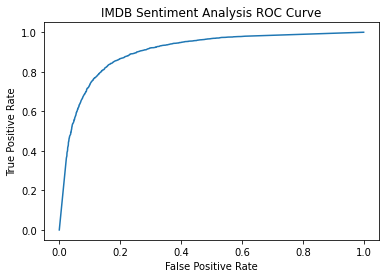

In [55]:
import matplotlib.pyplot as plt

# Create a Pipeline estimator and fit on train DF, predict on test DF
predictions = lr_pipeline.transform(validation_df)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('score','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['score'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('IMDB Sentiment Analysis ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

Lets estimate the accuracy:

In [56]:
lr_pipeline.transform(validation_df).\
    select(fn.expr('float(prediction = score)').alias('correct')).\
    select(fn.avg('correct')).show()

+------------------+
|      avg(correct)|
+------------------+
|0.8360111538972248|
+------------------+



The performance is much better than before.

The problem however is that we are overfitting because we have many features compared to the training examples:

For example, if we look at the weights of the features, there is a lot of noise:

In [57]:
import pandas as pd
vocabulary = idf_pipeline.stages[0].stages[-1].vocabulary
weights = lr_pipeline.stages[-1].coefficients.toArray()
print("num weights:", len(weights))
print("num rows:", validation_df.count())

coeffs_df = pd.DataFrame({'word': vocabulary, 'weight': weights})
coeffs_df.head()

num weights: 26677
num rows: 7531


,word,weight
0,br,-0.105915
1,s,0.181536
2,movie,-0.336467
3,film,0.194032
4,t,-0.783280


The most negative words are:

In [58]:
coeffs_df.sort_values('weight').head(5)

,word,weight
23658,zoolander,-6.642286
20947,grossness,-6.096098
25670,residue,-5.677060
24764,publicize,-5.493201
23439,dodgeball,-5.350357


And the most positive:

In [59]:
coeffs_df.sort_values('weight', ascending=False).head(5)

,word,weight
21116,choco,7.881534
26059,silhouetted,7.406967
25130,eliciting,6.151619
20935,praiseworthy,6.142447
13432,shrewd,5.979843


But none of them make sense. What is happening? We are overfitting the data. Those words that don't make sense are capturing just noise in the reviews.

# Regularization

One way to prevent overfitting during training is to modify the loss function and penalize weight values that are too large.

There are two major regularization techniques, one based on penalizing the squared value of the weight (called L2 or ridge regularization) and another based on penalizing the absolute value of the weight (called L1 or lasso regularization).

The unregularized logistic regression loss function is:

\begin{equation}
L_\theta(p(X),Y) = - \left( \sum_i Y_i \log p_\theta(X_i) + (1-Y_i)\log (1-p_\theta(X_i)) \right)
\end{equation}

where $p_\theta(\cdot)$ is the sigmoid function:

\begin{equation}
p_\theta(X) = \frac{1}{1+\exp(-(\theta_0 + \sum_{j>0} x_j \theta_j))}
\end{equation}

If we modify the loss function $L_\theta$ slightly

\begin{equation}
L_\theta^{\lambda}(p(X),Y) = -\left( \sum_i Y_i \log p_\theta(X_i) + (1-Y_i)\log(1-p_\theta(X_i)) \right) + \lambda \sum_{j>0} \theta_j^2
\end{equation}

we obtain what is known as L2 regularization.

Notice how we increase the loss function by $\lambda$ times the square of the weights. In practice, this means that __we will think twice about increasing the importance of a feature__. This loss function will prevent the algorithm for fitting certain data points, such as outliers or noise, unless the decrease in loss for the data grants it. Also, notice that the penalization doesn't apply to the bias parameter $\theta_0$.

You can see more clearly the effect of such cost function when $\lambda$ goes to infinity: the features will not be used for predicting and only the bias term will matter! This prevents the algorithm from learning altogether, forcing it to underfit!

One problem with L2 regularization is that all weights go to zero uniformly. In a sense, all features will matter but less than with the unregularized loss function. This is a really strange because we do not want all features to matter. In sentiment analysis, we want to select certain features because we want to understand that only some words have effects on the sentiment.

A different modification of the original loss function can achieve this. This regularization is known as L1 or lasso reguarlization and penalizes the _absolute_ value of the weight

\begin{equation}
L_\theta^{\lambda}(p(X),Y) = -\left( \sum_i Y_i \log p_\theta(X_i) + (1-Y_i)\log(1-p_\theta(X_i)) \right) + \lambda \sum_{j>0} \left| \theta_j \right|
\end{equation}

The practical effect of L1 regularization is that the difference between a feature having no importance vs some small importance is massively bigger than with L2 regularization. __Therefore, optimizing the L1 loss function usually brings some features to have exactly zero weight.__

One problem with L1 regularization is that it will never select more features than the number of examples. This is because it can always fit the training data perfectly when the number of features equals the number of examples. In our sentimental analysis, this is the case (there are more words than examples).

One way of remedying this is to have a combination of both L1 and L2. This is known as __elastic net regularization__. For this type of regularization, we have to pick a parameter ($\alpha$) deciding to consider L1 vs L2 regularization. If $\alpha=0$, then we choose L2, and if $\alpha=1$ we choose L1. For example, $\alpha=0.5$ means half L1 and half L2.

\begin{equation}
L_\theta^{\lambda,\alpha}(p(X),Y) = -\left( \sum_i Y_i \log p_\theta(X_i) + (1-Y_i)\log (1-p_\theta(X_i)) \right) + \lambda \left[(1-\alpha) \sum_{j>0} \theta_j^2 + \alpha \sum_{j>0} \left| \theta_j \right| \right]
\end{equation}

Unfortunately, elastic net regularization comes with two additional parameters, $\lambda$ and $\alpha$, and we must either select them a priori or use the validation set to choose the best one.

## Spark allows us to fit elastic net regularization easily

In [60]:
lambda_par = 0.02
alpha_par = 0.3
en_lr = LogisticRegression().\
        setLabelCol('score').\
        setFeaturesCol('tfidf').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)

And we define a new Pipeline with all steps combined

In [61]:
en_lr_estimator = Pipeline(stages=[tokenizer, sw_filter, cv, idf, en_lr])

In [62]:
en_lr_pipeline = en_lr_estimator.fit(training_df)

Let's look at the performance

In [63]:
en_lr_pipeline.transform(validation_df).select(fn.avg(fn.expr('float(prediction = score)'))).show()

+-------------------------+
|avg((prediction = score))|
+-------------------------+
|       0.8688089231177798|
+-------------------------+



We improve performance slightly, but whats more important is that we improve the understanding of the word sentiments. Lets look at the weights:

In [64]:
en_weights = en_lr_pipeline.stages[-1].coefficients.toArray()
en_coeffs_df = pd.DataFrame({'word': en_lr_pipeline.stages[2].vocabulary, 'weight': en_weights})

The most negative words all make sense ("worst" is _actually_ more negative than than "worse")!

In [65]:
en_coeffs_df.sort_values('weight').head(15)

,word,weight
105,worst,-0.369188
261,waste,-0.334131
190,awful,-0.259531
12,bad,-0.238970
606,poorly,-0.185563
522,dull,-0.185538
1113,disappointment,-0.181951
184,boring,-0.180375
179,poor,-0.177850
243,worse,-0.173731


Same thing with positive words

In [66]:
en_coeffs_df.sort_values('weight', ascending=False).head(15)

,word,weight
13,great,0.283820
161,excellent,0.240269
221,wonderful,0.200133
26,best,0.168678
300,favorite,0.161667
227,perfect,0.157898
286,amazing,0.142479
890,incredible,0.139636
271,loved,0.133010
2052,refreshing,0.129359


Are there words with _literarily_ zero importance for predicting sentiment? Yes, and most of them!

In [67]:
en_coeffs_df.query('weight == 0.0').shape

(19609, 2)

In fact, approximately 95% of features are not needed to achieve a __better__ performance than all previous models!

In [68]:
en_coeffs_df.query('weight == 0.0').shape[0]/en_coeffs_df.shape[0]

0.9502786527744124

Let's look at these _neutral_ words

In [69]:
en_coeffs_df.query('weight == 0.0').head(15)

,word,weight
0,br,0.0
3,film,0.0
5,like,0.0
9,story,0.0
10,really,0.0
11,people,0.0
14,don,0.0
15,way,0.0
17,movies,0.0
18,think,0.0


But, did we choose the right $\lambda$ and $\alpha$ parameters? We should run an experiment where we try different combinations of them. Fortunately, Spark let us do this by using a grid - a method that generates combination of parameters.

In [70]:
from pyspark.ml.tuning import ParamGridBuilder

We need to build a new estimator pipeline

In [71]:
en_lr_estimator.getStages()

[RegexTokenizer_30dc5ea13bfd,
 StopWordsRemover_f4d7e486133e,
 CountVectorizer_90f166836bbc,
 IDF_c6406b15572a,
 LogisticRegression_e9e2477f0e22]

In [72]:
grid = ParamGridBuilder().\
    addGrid(en_lr.regParam, [0., 0.01, 0.02]).\
    addGrid(en_lr.elasticNetParam, [0., 0.2, 0.4]).\
    build()

This is the list of parameters that we will try:

In [73]:
grid

[{Param(parent='LogisticRegression_e9e2477f0e22', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
  Param(parent='LogisticRegression_e9e2477f0e22', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0},
 {Param(parent='LogisticRegression_e9e2477f0e22', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
  Param(parent='LogisticRegression_e9e2477f0e22', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.2},
 {Param(parent='LogisticRegression_e9e2477f0e22', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
  Param(parent='LogisticRegression_e9e2477f0e22', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.4},
 {Pa

In [74]:
all_models = []
for j in range(len(grid)):
    print("Fitting model {}".format(j+1))
    model = en_lr_estimator.fit(training_df, grid[j])
    all_models.append(model)

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9


In [75]:
# estimate the accuracy of each of them:
accuracies = [m.\
    transform(validation_df).\
    select(fn.avg(fn.expr('float(score = prediction)')).alias('accuracy')).\
    first().\
    accuracy for m in all_models]

In [76]:
accuracies

[0.8389324126941973,
 0.8389324126941973,
 0.8389324126941973,
 0.8633647589961493,
 0.8794316823794981,
 0.8729252423316957,
 0.8678794316823795,
 0.8761120701102111,
 0.8600451467268623]

In [77]:
import numpy as np

In [78]:
best_model_idx = np.argmax(accuracies)
print("best model index =", best_model_idx)

best model index = 4


So the best model we found has the following parameters

In [79]:
grid[best_model_idx]

{Param(parent='LogisticRegression_e9e2477f0e22', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
 Param(parent='LogisticRegression_e9e2477f0e22', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.2}

In [80]:
best_model = all_models[best_model_idx]

In [81]:
accuracies[best_model_idx]

0.8794316823794981

In [82]:
# estimate generalization performance
best_model.\
    transform(testing_df).\
    select(fn.avg(fn.expr('float(score = prediction)')).alias('accuracy')).\
    show()

+------------------+
|          accuracy|
+------------------+
|0.8687674511368169|
+------------------+



## Finally, predicting tweet sentiments

Now we can use this model to predict sentiments on Twitter

In [83]:
tweets_df = spark.read.parquet('tweets.parquet')

We have 1K tweets from each candidate

In [84]:
tweets_df.groupby('handle').agg(fn.count('*')).show()

+----------------+--------+
|          handle|count(1)|
+----------------+--------+
| @HillaryClinton|    1000|
|@realDonaldTrump|    1000|
+----------------+--------+



We can now predict the sentiment of the Tweet using our best model, we need to rename the column so that it matches our previous pipeline (`review` => ...)

In [85]:
best_model.transform(tweets_df.withColumnRenamed('text', 'review')).select('handle', 'review', 'prediction').show()

+---------------+--------------------+----------+
|         handle|              review|prediction|
+---------------+--------------------+----------+
|@HillaryClinton|RT @ZekeJMiller: ...|       1.0|
|@HillaryClinton|“She’s just out t...|       1.0|
|@HillaryClinton|We're going to ma...|       0.0|
|@HillaryClinton|Don't boo. Vote! ...|       0.0|
|@HillaryClinton|This Republican d...|       0.0|
|@HillaryClinton|Hillary teamed up...|       1.0|
|@HillaryClinton|RT @mayaharris_: ...|       1.0|
|@HillaryClinton|"It was overwhelm...|       1.0|
|@HillaryClinton|Great step forwar...|       1.0|
|@HillaryClinton|"I feel like I'm ...|       1.0|
|@HillaryClinton|Nobody here was “...|       1.0|
|@HillaryClinton|For those few peo...|       0.0|
|@HillaryClinton|Remember, don't b...|       1.0|
|@HillaryClinton|Too many talented...|       1.0|
|@HillaryClinton|There are hundred...|       0.0|
|@HillaryClinton|It's 3:20am. As g...|       1.0|
|@HillaryClinton|Trump stood on a ...|       0.0|


Now, lets summarize our results in a graph!

In [86]:
%matplotlib inline

In [87]:
import seaborn

In [88]:
sentiment_pd = best_model.\
    transform(tweets_df.withColumnRenamed('text', 'review')).\
    groupby('handle').\
    agg(fn.avg('prediction').alias('ave_prediction'), (2*fn.stddev('prediction')/fn.sqrt(fn.count('*'))).alias('std_err')).\
    toPandas()

In [89]:
sentiment_pd.head()

,handle,ave_prediction,std_err
0,@HillaryClinton,0.571,0.031318
1,@realDonaldTrump,0.702,0.028942


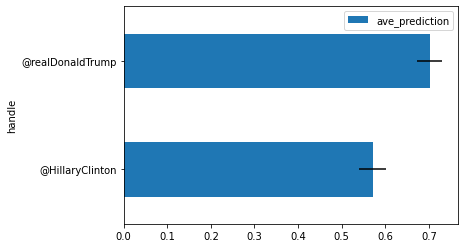

In [90]:
sentiment_pd.plot(x='handle', y='ave_prediction', xerr='std_err', kind='barh');

But let's examine some "negative" tweets by Trump

In [91]:
best_model.\
    transform(tweets_df.withColumnRenamed('text', 'review')).\
    where(fn.col('handle') == '@realDonaldTrump').\
    where(fn.col('prediction') == 0).\
    select('review').\
    take(5)

[Row(review='Moderator: Hillary paid $225,000 by a Brazilian bank for a speech that called for “open borders.” That’s a quote! #Debate #BigLeagueTruth'),
 Row(review='TRUMP &amp; CLINTON ON IMMIGRATION\n#Debate #BigLeagueTruth https://t.co/OP4c7Jc8Ad'),
 Row(review='Hillary is too weak to lead on border security-no solutions, no ideas, no credibility.She supported NAFTA, worst deal in US history. #Debate'),
 Row(review='One of my first acts as President will be to deport the drug lords and then secure the border. #Debate #MAGA'),
 Row(review='Hillary Clinton will use American tax dollars to provide amnesty for thousands of illegals. I will put… https://t.co/ZpV33TfbR6')]

And Clinton

In [92]:
best_model.\
    transform(tweets_df.withColumnRenamed('text', 'review')).\
    where(fn.col('handle') == '@HillaryClinton').\
    where(fn.col('prediction') == 0).\
    select('review').\
    take(5)

[Row(review="We're going to make college debt-free for everyone in America. See how much you could save with Hillary's plan at… https://t.co/Fhzkubhpj7"),
 Row(review="Don't boo. Vote! https://t.co/tTgeqy51PU https://t.co/9un3FUVxoG"),
 Row(review='This Republican dad is struggling with the idea of his daughter growing up in a country led by Donald Trump. https://t.co/Tn3rQqJJKp'),
 Row(review="For those few people knocking public service, hope you'll reconsider answering the call to help others. Because we're stronger together."),
 Row(review="There are hundreds of thousands more @AmeriCorps applications than spots. Horrible! Let's expand it from 75,000 annual members to 250,000.")]

As you can see, there are lots of room for improvement.

## Part 2: Test yourself

1. From the IMDB dataframe (`imdb_reviews_df`), compute the average review length between positive and negative reviews. Hint: use the spark sql function `length`. In particular, as we imported the funcions with the name `fn` (using `from pyspark.sql import function as fn`), use `fn.length` with the name of the column.
2. In the IMDB review database, are positive reviews longer than negative reviews?
3. Using the sentiment dataframe `sentiments_df`, find the imdb reviews with the most number of negative words. __Hint__: You need to tokenize the `review` field in `imdb_review_df` and then join with `sentiments_df`. Finally, perform selection and summary query
4. Similar to 3, find the imdb review with the most number of positive words.

# Part 3: On your own

1) Using the best model fitted (`best_model`), estimate the generalization error in the testing set (`testing_df`)

2) One way of analyzing what is wrong with a model is to examine when they fail the hardest. In our case, we could do this by looking at cases in which logistic regression is predicting with high probability a positive sentiment when in fact the actual sentiment is negative. 

To extract the probability of positive sentiment, however, we must extract it from the prediction with a custom function.

In [93]:
from pyspark.ml import feature

In [94]:
from pyspark.sql import types

def probability_positive(probability_column):
    return float(probability_column[1])
func_probability_positive = fn.udf(probability_positive, types.DoubleType())

prediction_probability_df = best_model.transform(validation_df).\
    withColumn('probability_positive', func_probability_positive('probability')).\
    select('id', 'review', 'score', 'probability_positive')
prediction_probability_df.show()

+---------+--------------------+-----+--------------------+
|       id|              review|score|probability_positive|
+---------+--------------------+-----+--------------------+
|    neg_0|Story of a man wh...|  0.0|  0.4858256123045225|
| neg_1000|The plot for Desc...|  0.0| 0.23773092718405964|
|neg_10003|When I was little...|  0.0|6.864567527598009E-4|
|neg_10006|I don't know who ...|  0.0| 0.08939747035805601|
|neg_10012|This movie must b...|  0.0| 0.00807233188176526|
|neg_10014|I saw this movie ...|  0.0|  0.4521054644087883|
|neg_10019|Kareena Kapoor in...|  0.0|4.943247978200782E-4|
|neg_10022|Summer season is ...|  0.0|  0.6559859138052766|
|neg_10023|Shame on Yash Raj...|  0.0|2.732321286786909...|
|neg_10024|First lesson that...|  0.0| 0.03837454919442784|
|neg_10026|I had some expect...|  0.0|   0.567648231964683|
| neg_1003|OK, I am not Japa...|  0.0|  0.1600110998240235|
|neg_10033|I was very disple...|  0.0| 0.35063356024225045|
|neg_10034|If there is one f...|  0.0|2.

Analyze the worst predictions that are __very__ wrong and suggest some ways of improving the model. __Hint__: Do a query that would get the highest `probability_positive` values for cases where `score` is `0`, and vice versa.

3) Using the best model (`best_model`), predict the sentiment of the following sentences.

a) "Make America great again"

b) "Cats are not always the best companion"

c) "This sentence is not a sentence"